# Projet segmentation sémantique 2025 - Dataset SUIM

A rendre:
- Code
- Vos choix détaillés/expériences/interprétations/analyses
- Courbes d'apprentissage
- Tableaux de résultats
- Conclusion


In [ ]:
import logging
import os
import torch
import numpy
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

# Paramètres

In [ ]:
batch_size = 1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 5
path = 'data/train_val'
image_size = 256
learning_rate = 1e-3
num_classes = 8

In [ ]:
#         DataAugment
def random_rot_flip(image, label):
    k = numpy.random.randint(0, 4)
    image = numpy.rot90(image, k)
    label = numpy.rot90(label, k)
    axis = numpy.random.randint(0, 2)
    image = numpy.flip(image, axis=axis).copy()
    label = numpy.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    angle = numpy.random.randint(-40, 40)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

def randomGaussian(image, label, mean=0.2, sigma=0.3):
    def gaussianNoisy(im, mean=0.2, sigma=0.3):
        """
        Gaussian noise processing of images
        :param im: Single-channel images
        :param mean: Offset
        :param sigma: Standard deviation
        :return:
        """
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im

     # Converting images into arrays
    img = numpy.asarray(image)
    img.flags.writeable = True  # Changing arrays to read and write mode
    width, height = img.shape[:2]
    img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
    img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
    img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
    img[:, :, 0] = img_r.reshape([width, height])
    img[:, :, 1] = img_g.reshape([width, height])
    img[:, :, 2] = img_b.reshape([width, height])
    return numpy.uint8(img), label

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
            if random.random() > 0.5:
                image, label = randomGaussian(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
            if random.random() > 0.5:
                image, label = randomGaussian(image, label)
        elif random.random() > 0.5:
            image, label = randomGaussian(image, label)


        return image, label

# DataLoader

In [ ]:
class SUIM(Dataset):
    def __init__(self, img_path, label_path, transform = None):
        self.img_path = img_path
        self.label_path = label_path
        self.label_data = os.listdir(self.label_path)
        self.transform = transform # Data enhancement
        self.resize = transforms.Resize((image_size, image_size)) # Trimming of data
    def __len__(self):
        return len(self.label_data)  # Number of data returned

    def __getitem__(self, item):
        img_name = os.path.join(self.img_path, self.label_data[item]) # 'dataset/training/picture' +‘00001_matte.png’
        img_name = os.path.split(img_name) # 'dataset/training/picture/00001_matte.png' -> ('dataset/training/picture','00001_matte.png')
        img_name = img_name[-1] #'00001_matte.png'
        img_name = img_name.split('.')
        img_name = img_name[0] + '.jpg'   #  '00001' + ‘.png’ is the file name of the data
        img_data = os.path.join(self.img_path, img_name) # 'dataset/training/picture/00001.png'
        label_data =os.path.join(self.label_path, self.label_data[item])

        img = Image.open(img_data)
        label = Image.open(label_data)
        img = self.resize(img)
        label = self.resize(label)
#         print(numpy.shape(img))
        img = numpy.array(img)

        label = numpy.array(label)
        sample = {'image': img, 'label': label}
        if self.transform:
            img, label = self.transform(sample)

        return img, label


'''The dataloader is loaded, and when it is loaded, it is processed in the trainloader.（img，label）'''

train_dataset = SUIM('data/train_val/images',
                       'data/train_val/train_label',
                       transform=transforms.Compose(
                                   [RandomGenerator(output_size=[image_size, image_size])]))

test_data = SUIM('data/test/images', 'data/test/test_label', transform=None)

train_data, val_data = torch.utils.data.random_split(train_dataset, [1220, 305], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=0,
                          drop_last=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=0,
                          drop_last=True)

test_loader = DataLoader(test_data, batch_size=1,
                          shuffle=False, num_workers=0,
                          drop_last=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_val/train_label'

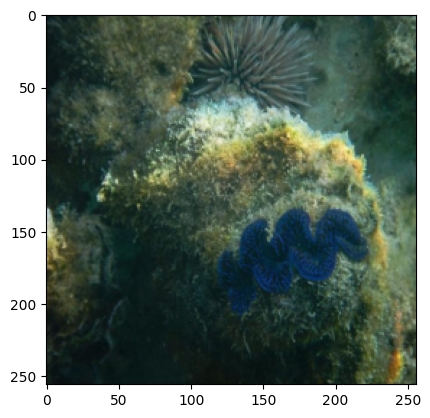

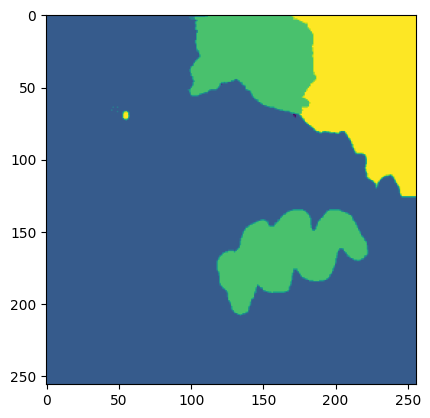

In [ ]:
for data, mask in train_loader:
    data1 = data[0]
    plt.imshow(data1)
    plt.show()
    plt.imshow(mask[0])
#     print(mask[0],mask[0].shape)
#     print(mask[0].numpy())
    plt.show()
    break

# Idées pour la suite du projet:
- Implémenter une/plusieurs architectures de segmentation semantique
- Faire l'entrainement/optimisation des hyperparamètres
- Utiliser des modèles pré-entrainés si souhaité
- Augmentation de données
- Evaluation
- Visualisation, mise en forme des résultats, interpétation
- Comparaison entre plusieurs architectures
- Analyse/commentaires/idées pour améliorer les performances/modèles

A vous de jouer ;)